# Data Evaluation
- This jupyter notebook is used to evaluate the data generated by the experiments
- Mainly it will calculate the C-Metric for the different pareto fronts in the dataset

## Imports

In [901]:
import os
import fnmatch
import pandas as pd
import numpy as np
import ast
import pickle as p
import matplotlib.pyplot as plt
from copy import deepcopy
import seaborn as sns

In [902]:
base_path = '/Users/carlonue/Documents/Venvs/pathpave_pymoo/log_all_final/meanderingRiverMap'

In [903]:
def plot2PointLists(points1, points2):
    plt.figure(figsize=(8, 6))
    list1 = np.array(points1)
    list2 = np.array(points2)
    plt.scatter(list2[:, 0], list2[:, 1], color='red', label='Point List 1')
    plt.scatter(list1[:, 0], list1[:, 1], color='blue', label='Point List 2')
    
    # Add labels and title
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    #plt.title(f"Non Dominated Points of all Algorithms for Map {nonDominatedPoints[0]['map']} and shifting method {nonDominatedPoints[0]['shiftingMethod']}")
    
    # Add a legend
    plt.legend()
    
    # Show the plot
    plt.grid(True)
    #plt.show()

## Get Map Directories

In [904]:
def getMapDirs(pattern: str, dirList: list):
    """Parses the log directory and returns the paths of the directories matching the supplied pattern."""
    matchingDirs = []
    for dir in dirList:
        if fnmatch.fnmatch(dir, pattern):
            if not fnmatch.fnmatch(dir, "*_0_*"): #Exclude random shifting since data is shit
                matchingDirs.append(dir)
    #print(f"Found {len(matchingDirs)} directories for pattern {pattern} ...")
    return matchingDirs

## Get Pareto Dominance of 2 Datapoints

In [905]:
def getDominance(point1: tuple, point2: tuple) -> bool:
    """This function determines if the first datapoint dominates the second one."""
    at_least_as_good = all(x <= y for x, y in zip(point1, point2))
    
    # Check if `a` is strictly better than `b` in at least one objective
    strictly_better = any(x < y for x, y in zip(point1, point2))

    returnValue = (at_least_as_good and strictly_better)
    #if returnValue:
    #    print(f"{point1} dominates {point2}")
    return returnValue

## Divide Data

In [906]:
def divideData(dirs: list):
    """Creates Objects from dir list."""
    basePath = base_path
    obj = {'algorithm': None,
           'map': None,
           'shiftingMethod': None,
           'objectiveValues': []}
    
    for dir in dirs:
        file = pd.read_csv(basePath+"/"+dir+"/optLog.csv").tail(1)
        map = file[' map'].values[0]
        shiftingMethod = file[' shiftingMethod'].values[0]
        #print(f"shiftingethod is {dir}")
        objectiveValues = ast.literal_eval(file[' objectiveValues'].values[0])
        algo = file[' algorithm'].values[0]

        if obj['map'] is None:
            obj['map'] = map
            obj['shiftingMethod'] = shiftingMethod
            obj['objectiveValues'] += objectiveValues
            obj['algorithm'] = algo
        else:
            obj['objectiveValues'] += objectiveValues
    #print(f"Number of unflitered datapoints is {len(obj['objectiveValues'])}")

    #remove doubled datapoints
    seen = set()
    unique_list = []
    for item in obj['objectiveValues']:
    # Convert the list to a tuple for hashable comparison
        tuple_item = tuple(item)
        if tuple_item not in seen:
            unique_list.append(item)  # Keep the original list format
            seen.add(tuple_item)
    obj['objectiveValues'] = unique_list
    #print(f"Doubled datapoints removed, number of dp now {len(obj['objectiveValues'])}")

    #now filter for non dominated objectiveValues
    pareto_optimal = []
    
    for i, p in enumerate(obj['objectiveValues']):
        is_dominated = False
        for j, q in enumerate(obj['objectiveValues']):
            if i != j and getDominance(q, p):
                is_dominated = True
                break
        if not is_dominated:
            pareto_optimal.append(p)
    obj['objectiveValues'] = pareto_optimal
    if False:
        plot2PointLists(unique_list, obj['objectiveValues'])
    
    #print(f"Number of non dominated datapoints is {len(obj['objectiveValues'])}")

    return obj

## Loading the Data

In [907]:
def loadData(map, algorithms: list, shiftingMethod = 1):
    """Loads the data that has to be evaluated"""
    # List content of log directory -> directories of runs
    logPath = base_path
    dirList = os.listdir(logPath)
    allNonDominated = []
    if os.path.exists(logPath + "/results.csv"):
        print("Removed results.csv from dir list ...")
        dirList.remove("results.csv")
    mapDirs = getMapDirs(f"*{map}_*", dirList)
    #print(len(mapDirs))
    for algo in algorithms:
        algo1Dirs = [dir for dir in mapDirs if fnmatch.fnmatch(dir, f"*_{algo}_*")]
        #print(f"Found {len(algo1Dirs)} dirs for {algo}")
        algo1Filtered = [dir for dir in algo1Dirs if fnmatch.fnmatch(dir, f"*_{shiftingMethod}_*")]
        #print(f"Found {len(algo1Filtered)} dirs for {shiftingMethod}")
        allNonDominated.append(divideData(algo1Filtered))
        print(f"Got all non dominated points for {algo} ...")

    return allNonDominated


## C-Metric

In [908]:
def getCMetric(nonDominatedPoints: list):
    enableScatterPlot = True
    enableHeatmap = True
    #print(nonDominatedPoints)
    obj1 = nonDominatedPoints[0]
    obj2 = nonDominatedPoints[1]

    metricValueAB = None
    metricValueBA = None

    #Just graphic to illustrate if everything is ok
    labels=['List 1', 'List 2']
    pointArrays = [np.array(x['objectiveValues']) for x in nonDominatedPoints] #Create np arrays for scatter plot
    colorList = ['blue', 'green', 'yellow', 'red', 'black', 'orange', 'cyan']
    algorithms = ["NSGA2", "NSGA3", "SPEA2", "RNSGA2", "AGEMOEA", "DNSGA2", "SMSEMOA"]
    # Create a new figure
    if enableScatterPlot:
        plt.figure(figsize=(8, 8))
    
        # Plot the first list of points
        for i in range(len(pointArrays)):
            plt.scatter(pointArrays[i][:, 0], pointArrays[i][:, 1], color=colorList[i], label=algorithms[i], s=80)
    
        # Add labels and title
        plt.xlabel('Path Length', fontsize=25)
        plt.ylabel('Weight Shifted', fontsize=25)
        #plt.title(f"Non Dominated Points of all Algorithms for Map {nonDominatedPoints[0]['map']} and shifting method {nonDominatedPoints[0]['shiftingMethod']}")
        print(f"Non Dominated Points of all Algorithms for Map {nonDominatedPoints[0]['map']}")
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        # Add a legend
        legend = plt.legend(fontsize=22)
        for handle in legend.legend_handles:
            handle._sizes = [150]
        # Show the plot
        plt.grid(True)
        plt.show()


    heatMapValues = [] #this list contains nested lists with all c-metric values for each algorithm

    for i in range(len(nonDominatedPoints)):
        cMetricValues = []
        for j in range(len(nonDominatedPoints)):
            #plot2PointLists(nonDominatedPoints[i]['objectiveValues'], nonDominatedPoints[j]['objectiveValues'])
            numberOfDom = 0
            if i != j:
                #points1 = deepcopy(nonDominatedPoints[i]['objectiveValues'])
                #points2 = deepcopy(nonDominatedPoints[j]['objectiveValues'])
                if (len(nonDominatedPoints[j]['objectiveValues']) == 1) and (nonDominatedPoints[j]['objectiveValues']==nonDominatedPoints[i]['objectiveValues']):
                    cMetricValues.append(np.inf)
                    continue

                #Remove dominated points for calulation
                #Count dominateds and divide by total number
                for x in nonDominatedPoints[j]['objectiveValues']:
                    for y in nonDominatedPoints[i]['objectiveValues']:
                        if getDominance(y, x):
                            numberOfDom += 1
                            break
                #Number of non dom / total number of datapoints
                cMetricValue = numberOfDom / len(nonDominatedPoints[j]['objectiveValues'])
                #print(f"C-Metric Value for {nonDominatedPoints[i]['algorithm']} and {nonDominatedPoints[j]['algorithm']}: {cMetricValue} or {numberOfDom} / {len(nonDominatedPoints[j]['objectiveValues'])}")
                cMetricValues.append(cMetricValue)
            else:
                cMetricValues.append(np.nan)

        heatMapValues.append(cMetricValues)
    
    print(f"HeatMapValues: {heatMapValues}")
    
    for i in range(len(heatMapValues)):
        counter = 0
        average_of_dominated_solutions = 0
        for j in range(len(heatMapValues[i])):
            if (heatMapValues[i][j]>=0):
                counter += 1
                average_of_dominated_solutions += heatMapValues[i][j]
        print(counter)
        average_of_dominated_solutions = average_of_dominated_solutions/counter
        print(f"results: {average_of_dominated_solutions} <-----------------------------------------------------------------------------------------------")

    
    if enableHeatmap:
        # Create the heatmap
        diagonalMask = np.zeros_like(heatMapValues, dtype=bool)
        for i in range(len(algorithms)):
            for j in range(len(algorithms)):
                if i == j:
                    diagonalMask[i,j] = True
        
        plt.figure(figsize=(9, 9))
        #plt.title(f"C-Metric Values for Map {nonDominatedPoints[0]['map']} and shifting method {nonDominatedPoints[0]['shiftingMethod']}")
        cmap = sns.color_palette("RdYlGn", as_cmap=True)
        ax = sns.heatmap(heatMapValues, annot=False, cmap=cmap, 
                 xticklabels=algorithms, yticklabels=algorithms, 
                 mask=diagonalMask, cbar=True, 
                 linewidths=0.5, linecolor='black',
                 vmin=0, vmax=1)
        
        
        # Set the facecolor of masked cells to gray
        #plt.title(f"Heatmap: {nonDominatedPoints[0]['shiftingMethod']}")
        ax.set_facecolor('gray')
        ax.set_xticklabels(algorithms, rotation=40, ha='right', fontsize=30)
        ax.set_yticklabels(algorithms, rotation=40, ha='right', fontsize=30)
        #print(f"C-Metric Values for Map {nonDominatedPoints[0]['map']} and shifting method {nonDominatedPoints[0]['shiftingMethod']}")

        # Modify the color bar
        cbar = ax.collections[0].colorbar  # Get the colorbar
        cbar.set_label('C-Metric Values', fontsize=30)  # Add label to the colorbar
        cbar.ax.tick_params(labelsize=25) 
        
        plt.show()
    

## Main

Loading data for meanderingRiverObstacles, 1
Got all non dominated points for NSGA2 ...
Got all non dominated points for NSGA3 ...
Got all non dominated points for SPEA2 ...
Got all non dominated points for RNSGA2 ...
Got all non dominated points for AGEMOEA ...
Got all non dominated points for DNSGA2 ...
Got all non dominated points for SMSEMOA ...
Non Dominated Points of all Algorithms for Map meanderingRiverObstacles


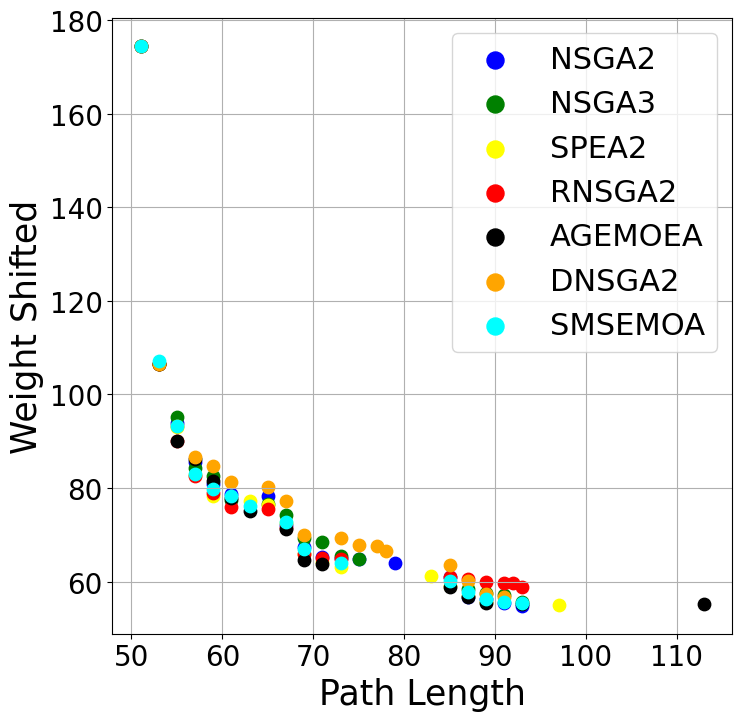

HeatMapValues: [[nan, 0.625, 0.1875, 0.35294117647058826, 0.3333333333333333, 0.8235294117647058, 0.4], [0.2222222222222222, nan, 0.0, 0.29411764705882354, 0.13333333333333333, 0.6470588235294118, 0.13333333333333333], [0.6666666666666666, 0.8125, nan, 0.5294117647058824, 0.2, 0.8823529411764706, 0.8], [0.5555555555555556, 0.5625, 0.375, nan, 0.26666666666666666, 0.7058823529411765, 0.5333333333333333], [0.6666666666666666, 0.75, 0.5625, 0.6470588235294118, nan, 0.8823529411764706, 0.8], [0.05555555555555555, 0.1875, 0.0, 0.29411764705882354, 0.0, nan, 0.06666666666666667], [0.5, 0.8125, 0.125, 0.4117647058823529, 0.13333333333333333, 0.8823529411764706, nan]]
6
results: 0.4537173202614379 <-----------------------------------------------------------------------------------------------
6
results: 0.23834422657952067 <-----------------------------------------------------------------------------------------------
6
results: 0.6484885620915032 <---------------------------------------------

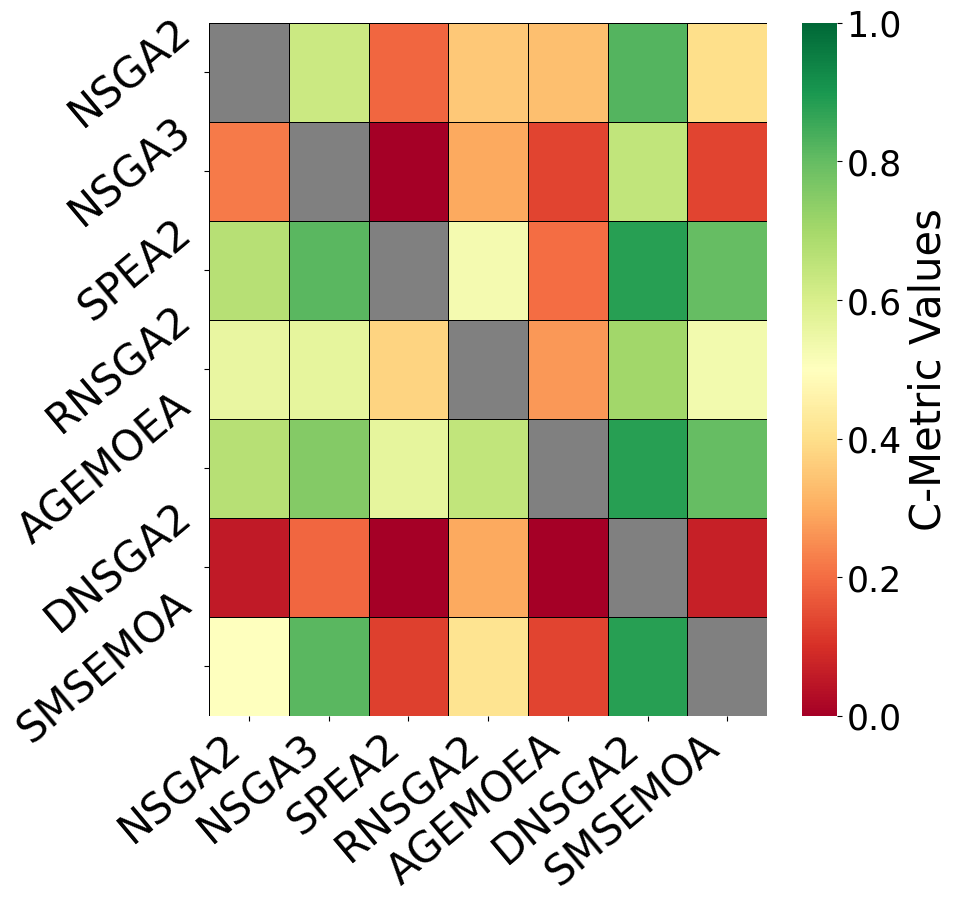

Loading data for meanderingRiverObstacles, 2
Got all non dominated points for NSGA2 ...
Got all non dominated points for NSGA3 ...
Got all non dominated points for SPEA2 ...
Got all non dominated points for RNSGA2 ...
Got all non dominated points for AGEMOEA ...
Got all non dominated points for DNSGA2 ...
Got all non dominated points for SMSEMOA ...
Non Dominated Points of all Algorithms for Map meanderingRiverObstacles


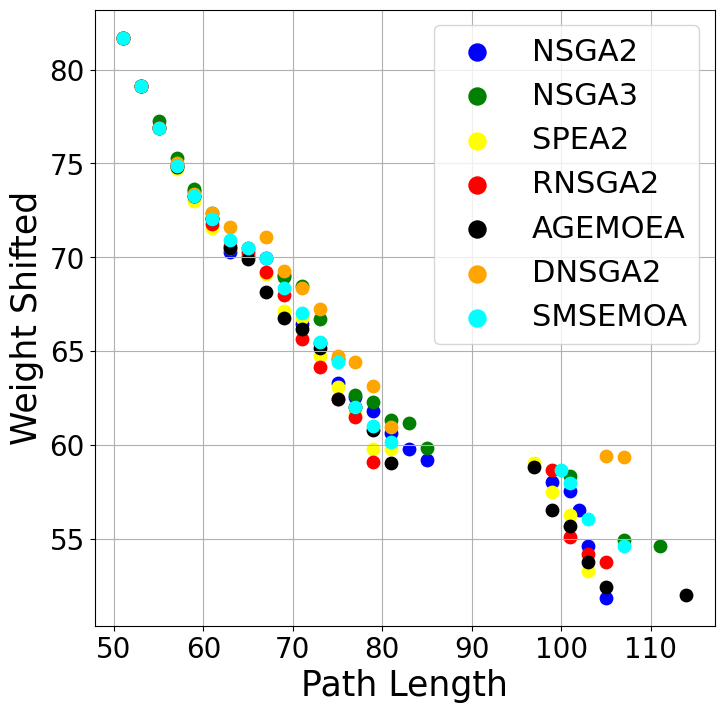

HeatMapValues: [[nan, 0.8421052631578947, 0.15, 0.2631578947368421, 0.13636363636363635, 0.8235294117647058, 0.45], [0.043478260869565216, nan, 0.0, 0.0, 0.0, 0.47058823529411764, 0.0], [0.6956521739130435, 0.8947368421052632, nan, 0.5789473684210527, 0.4090909090909091, 0.8823529411764706, 0.9], [0.6956521739130435, 0.8947368421052632, 0.35, nan, 0.3181818181818182, 0.8235294117647058, 0.75], [0.782608695652174, 0.8947368421052632, 0.45, 0.5263157894736842, nan, 0.8823529411764706, 0.75], [0.043478260869565216, 0.3684210526315789, 0.0, 0.05263157894736842, 0.0, nan, 0.0], [0.391304347826087, 0.7894736842105263, 0.0, 0.15789473684210525, 0.13636363636363635, 0.8823529411764706, nan]]
6
results: 0.4441927010038465 <-----------------------------------------------------------------------------------------------
6
results: 0.0856777493606138 <-----------------------------------------------------------------------------------------------
6
results: 0.7267967057844565 <----------------------

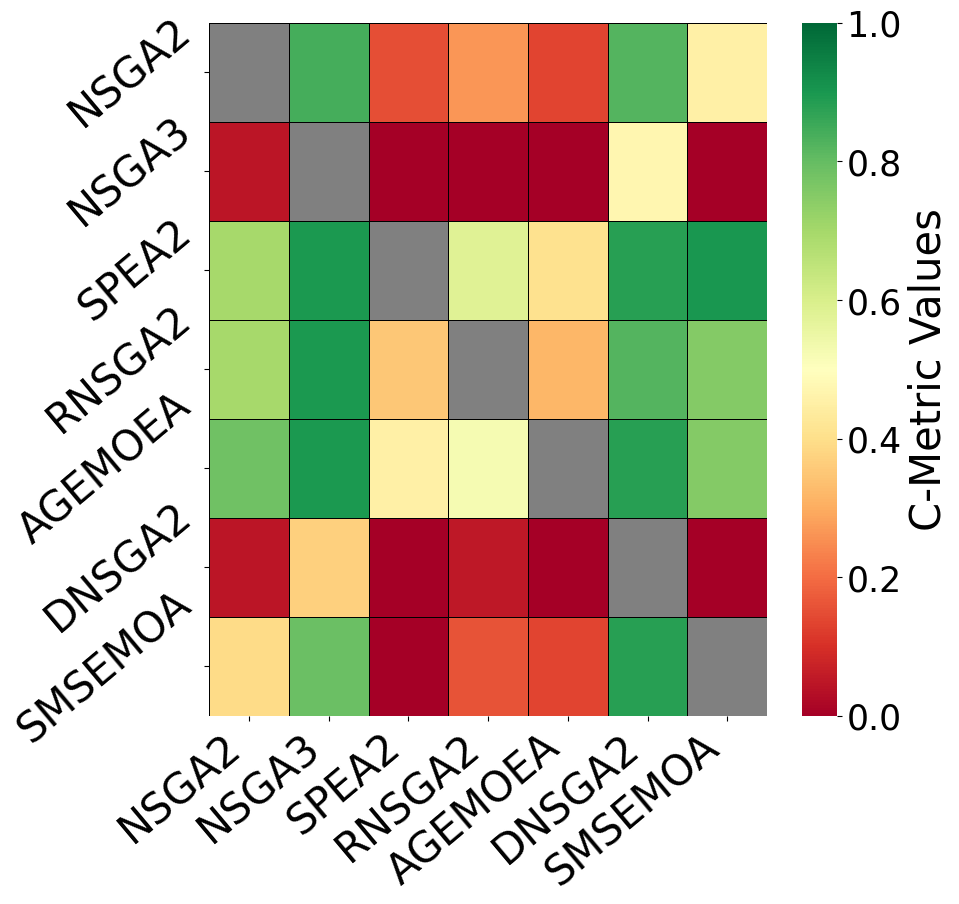

Loading data for meanderingRiverObstacles, 3
Got all non dominated points for NSGA2 ...
Got all non dominated points for NSGA3 ...
Got all non dominated points for SPEA2 ...
Got all non dominated points for RNSGA2 ...
Got all non dominated points for AGEMOEA ...
Got all non dominated points for DNSGA2 ...
Got all non dominated points for SMSEMOA ...
Non Dominated Points of all Algorithms for Map meanderingRiverObstacles


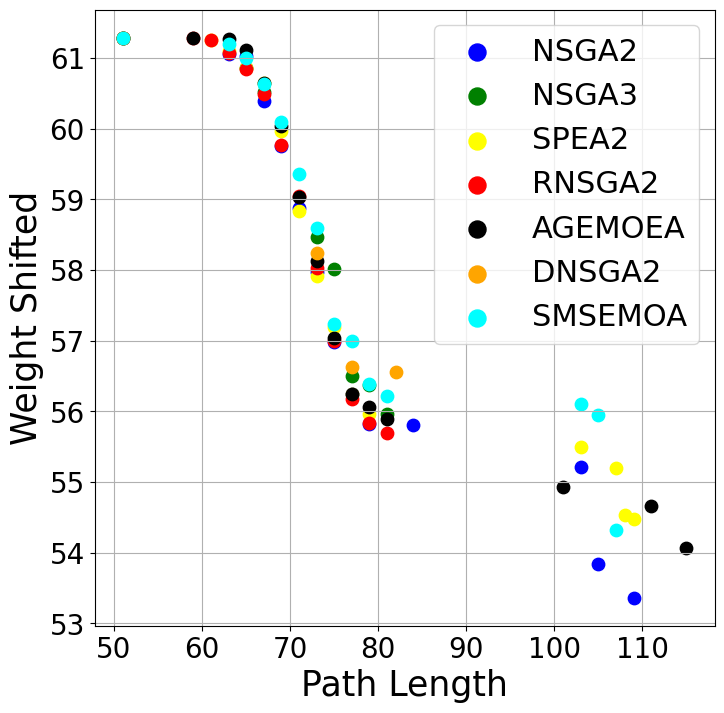

HeatMapValues: [[nan, 0.75, 0.6666666666666666, 0.5384615384615384, 0.8, 0.75, 0.8571428571428571], [0.07142857142857142, nan, 0.06666666666666667, 0.0, 0.13333333333333333, 0.5, 0.5], [0.21428571428571427, 0.75, nan, 0.23076923076923078, 0.6, 0.75, 0.7857142857142857], [0.21428571428571427, 0.875, 0.4666666666666667, nan, 0.6, 0.75, 0.8571428571428571], [0.07142857142857142, 0.625, 0.2, 0.07692307692307693, nan, 0.75, 0.6428571428571429], [0.0, 0.125, 0.0, 0.0, 0.0, nan, 0.14285714285714285], [0.07142857142857142, 0.125, 0.26666666666666666, 0.0, 0.26666666666666666, 0.25, nan]]
6
results: 0.727045177045177 <-----------------------------------------------------------------------------------------------
6
results: 0.2119047619047619 <-----------------------------------------------------------------------------------------------
6
results: 0.555128205128205 <-----------------------------------------------------------------------------------------------
6
results: 0.6271825396825397 <---

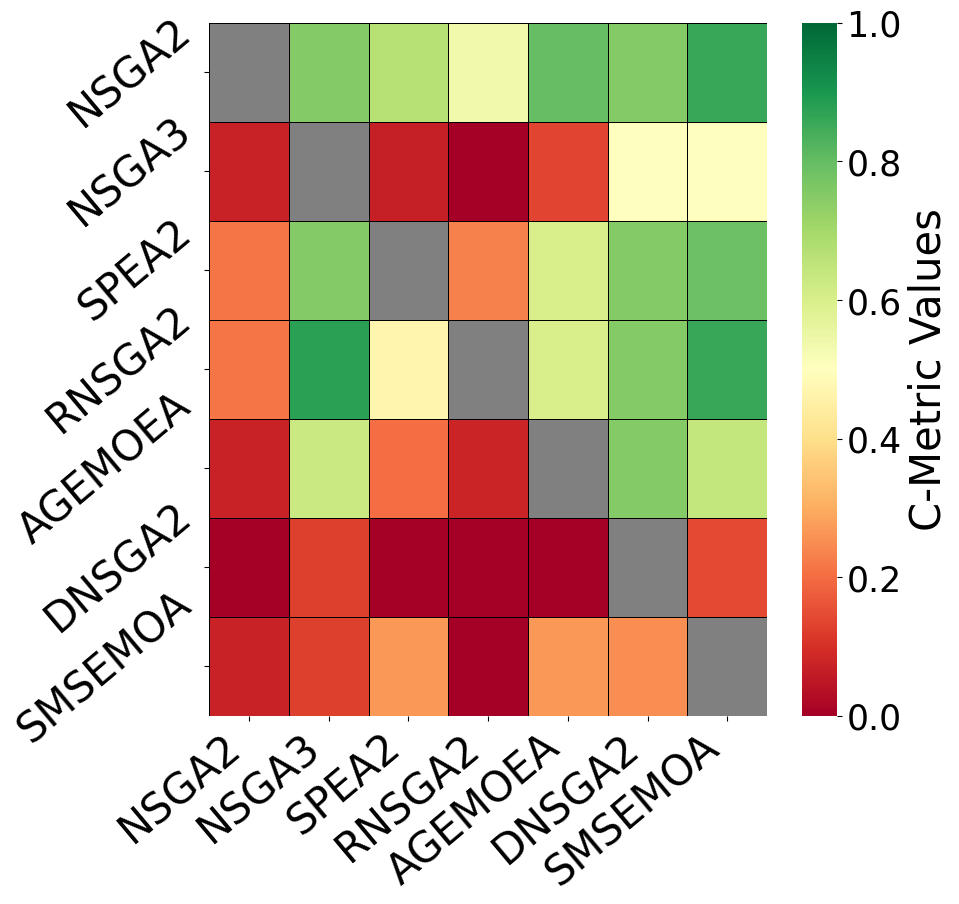

Loading data for meanderingRiverObstacles, 4
Got all non dominated points for NSGA2 ...
Got all non dominated points for NSGA3 ...
Got all non dominated points for SPEA2 ...
Got all non dominated points for RNSGA2 ...
Got all non dominated points for AGEMOEA ...
Got all non dominated points for DNSGA2 ...
Got all non dominated points for SMSEMOA ...
Non Dominated Points of all Algorithms for Map meanderingRiverObstacles


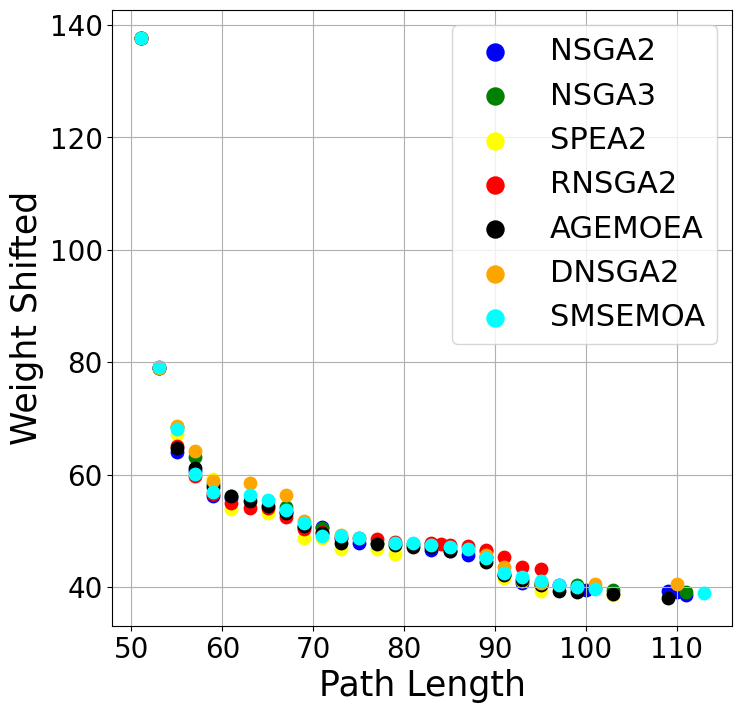

HeatMapValues: [[nan, 0.7058823529411765, 0.16666666666666666, 0.6086956521739131, 0.28, 0.9285714285714286, 0.72], [0.041666666666666664, nan, 0.05555555555555555, 0.2608695652173913, 0.04, 0.6428571428571429, 0.2], [0.75, 0.8235294117647058, nan, 0.782608695652174, 0.76, 0.8571428571428571, 0.92], [0.25, 0.35294117647058826, 0.2222222222222222, nan, 0.28, 0.5, 0.36], [0.5833333333333334, 0.8235294117647058, 0.1111111111111111, 0.6521739130434783, nan, 0.9285714285714286, 0.84], [0.0, 0.058823529411764705, 0.05555555555555555, 0.21739130434782608, 0.0, nan, 0.08], [0.16666666666666666, 0.5294117647058824, 0.05555555555555555, 0.43478260869565216, 0.12, 0.7857142857142857, nan]]
6
results: 0.5683026833921975 <-----------------------------------------------------------------------------------------------
6
results: 0.20682482171612604 <-----------------------------------------------------------------------------------------------
6
results: 0.815546827426623 <---------------------------

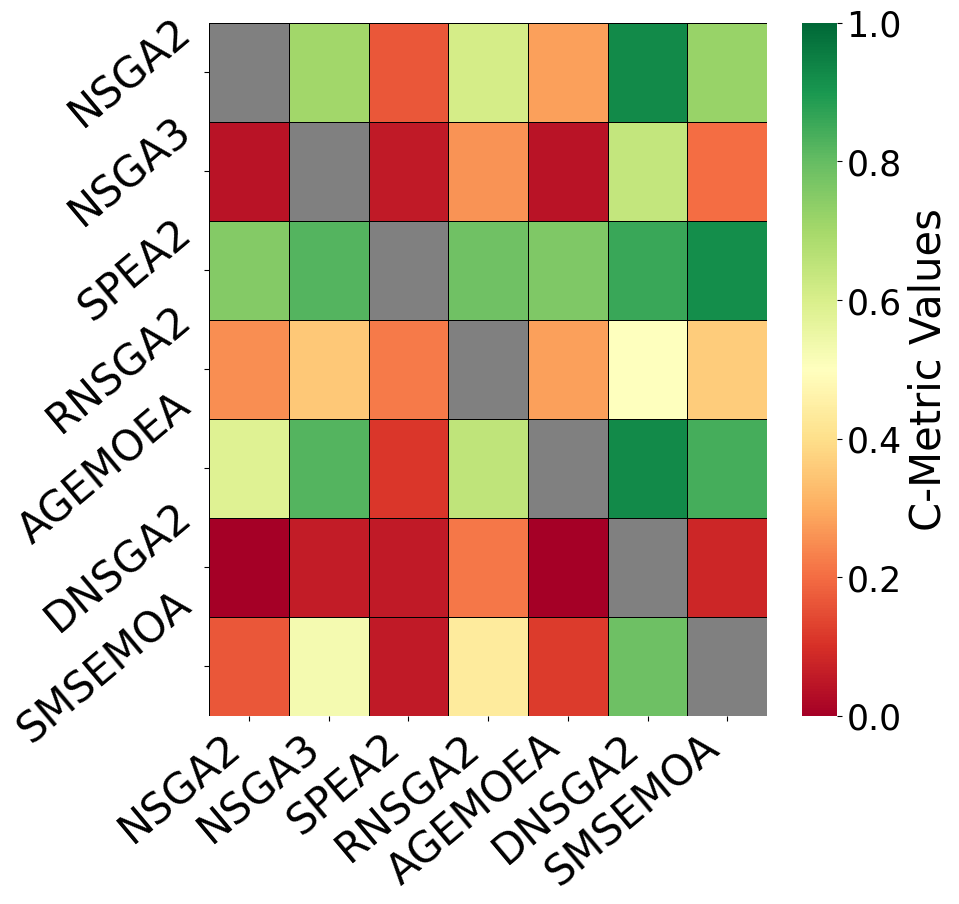

Loading data for meanderingRiverObstacles, 5
Got all non dominated points for NSGA2 ...
Got all non dominated points for NSGA3 ...
Got all non dominated points for SPEA2 ...
Got all non dominated points for RNSGA2 ...
Got all non dominated points for AGEMOEA ...
Got all non dominated points for DNSGA2 ...
Got all non dominated points for SMSEMOA ...
Non Dominated Points of all Algorithms for Map meanderingRiverObstacles


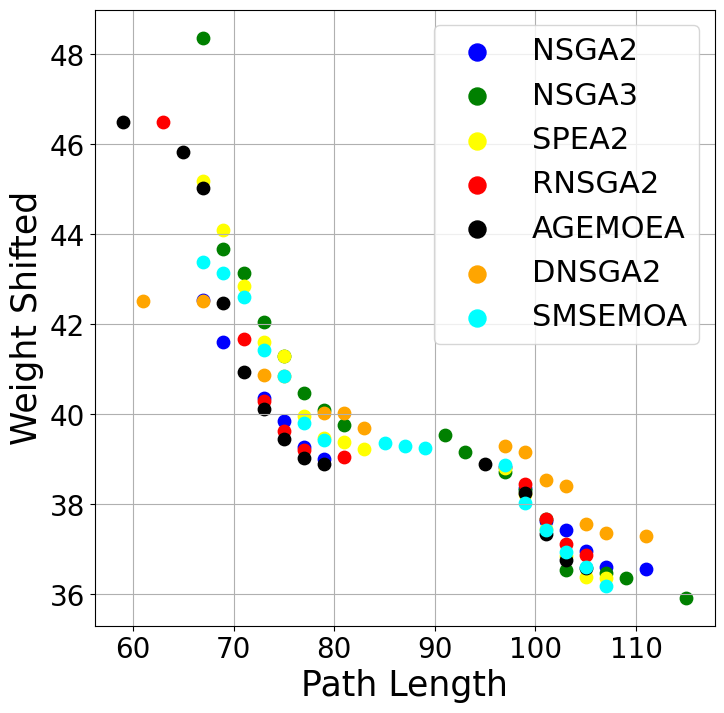

HeatMapValues: [[nan, 0.6470588235294118, 0.6, 0.4, 0.14285714285714285, 0.8571428571428571, 0.6875], [0.46153846153846156, nan, 0.2, 0.4, 0.14285714285714285, 0.5714285714285714, 0.1875], [0.5384615384615384, 0.6470588235294118, nan, 0.4, 0.14285714285714285, 0.7142857142857143, 0.375], [0.38461538461538464, 0.5294117647058824, 0.4666666666666667, nan, 0.0, 0.8571428571428571, 0.5], [0.6923076923076923, 0.7058823529411765, 0.7333333333333333, 1.0, nan, 0.8571428571428571, 0.75], [0.07692307692307693, 0.35294117647058826, 0.3333333333333333, 0.1, 0.14285714285714285, nan, 0.25], [0.46153846153846156, 0.7647058823529411, 0.6666666666666666, 0.4, 0.14285714285714285, 0.7857142857142857, nan]]
6
results: 0.5557598039215687 <-----------------------------------------------------------------------------------------------
6
results: 0.327220695970696 <-----------------------------------------------------------------------------------------------
6
results: 0.4696105365223013 <----------------

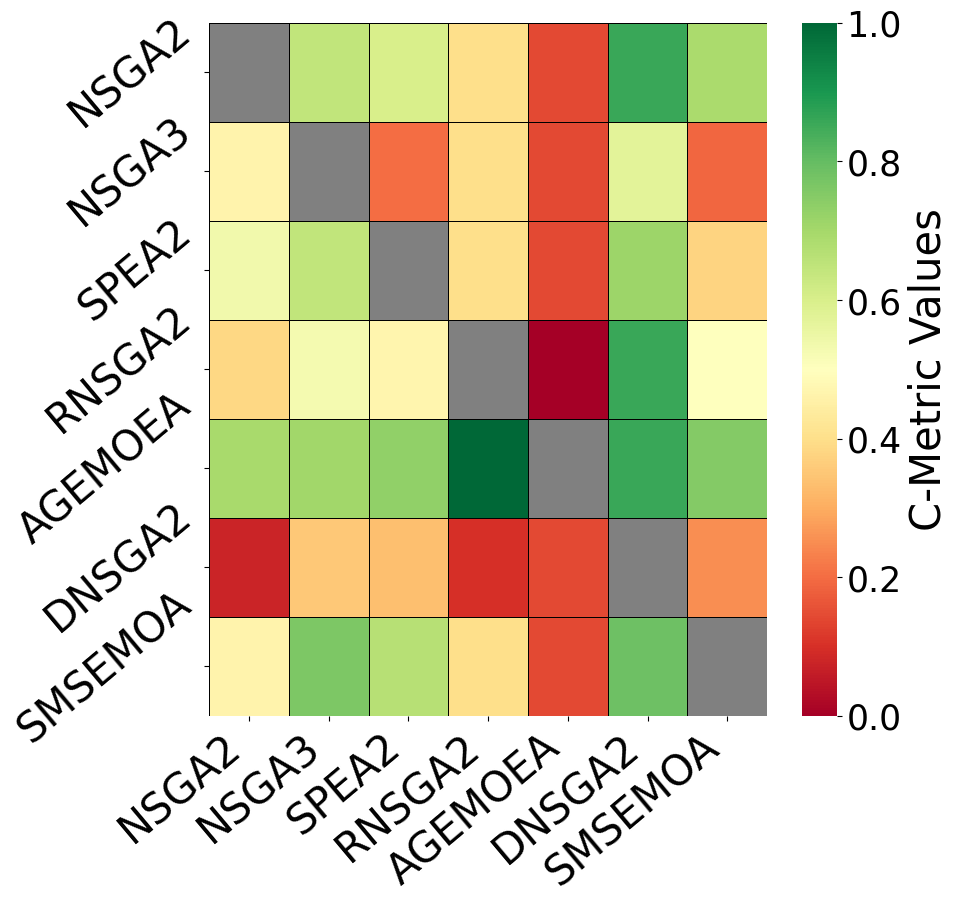

In [909]:
shiftingMethods = [1,2,3,4,5]
maps = ["gradientObstacles", "meanderingRiverObstacles", "radialGradientObstacles", "sinusoidalObstacles"]
algorithms = ["NSGA2", "NSGA3", "SPEA2", "RNSGA2", "AGEMOEA", "DNSGA2", "SMSEMOA"]
#algoCombinations = list(combinations(algorithms, 2))

for map in maps:
    dirList = os.listdir(base_path)
    if fnmatch.fnmatch(dirList[0], f"*{map}_*"):
        for shiftingMethod in shiftingMethods:
            print(f"Loading data for {map}, {shiftingMethod}")
            allNonDominatedPoints = loadData(map, algorithms, shiftingMethod)
            getCMetric(allNonDominatedPoints)
